In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data.csv')

print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Veri temizlendi! Yeni durum:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     

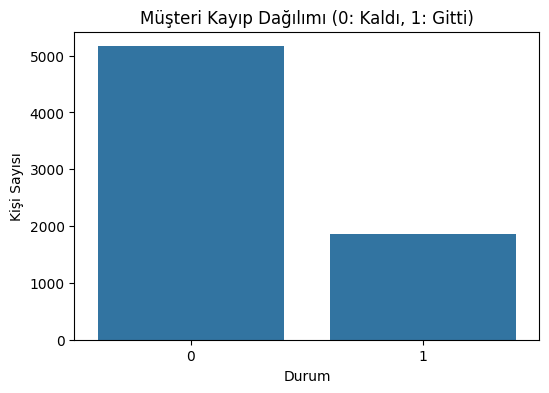

In [6]:
# --- VERİ TEMİZLEME ---

# 1. TotalCharges sütununu sayıya çevir (Hata veren boşlukları NaN yapar)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Boş değer oluşan (çok az sayıdaki) satırları sil
df.dropna(inplace=True)

# 3. Gereksiz 'customerID' sütununu sil
df.drop(columns=['customerID'], inplace=True)

# 4. Hedef değişkeni (Churn) sayıya çevir: Yes -> 1, No -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Veri temizlendi! Yeni durum:")
print(df.info())

# --- İLK GÖRSELLEŞTİRME: CHURN DAĞILIMI ---

# Kaç kişi gitmiş, kaç kişi kalmış?
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Müşteri Kayıp Dağılımı (0: Kaldı, 1: Gitti)")
plt.xlabel("Durum")
plt.ylabel("Kişi Sayısı")
plt.show() # PyCharm'da grafiği görmek için bu komut şarttır

In [8]:
# --- VERİ DÖNÜŞTÜRME (ENCODING) ---

# Tüm 'object' (yazı) olan sütunları otomatik bulup 0-1 formatına çeviriyoruz
# drop_first=True diyerek gereksiz tekrarı önlüyoruz (Örn: Erkek sütunu varsa Kadın sütununa gerek yok)
df = pd.get_dummies(df, drop_first=True)

print("Tüm veriler sayıya döndü!")
# print(df.info()) # İstersen kontrol için açabilirsin

# --- ANALİZ: Müşteriyi Kaçıran En Büyük Sebep Ne? ---

# Churn (Kayıp) ile diğer özellikler arasındaki ilişkiye (korelasyon) bakalım
correlation = df.corr()['Churn'].sort_values(ascending=False)

print("\nChurn ile en çok ilişkili özellikler:")
print(correlation.head(5)) # Churn'ü en çok artıranlar (Pozitif ilişki)
print("\nChurn'ü en çok engelleyen özellikler:")
print(correlation.tail(5)) # Churn'ü en çok azaltanlar (Negatif ilişki)

Tüm veriler sayıya döndü!

Churn ile en çok ilişkili özellikler:
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
Name: Churn, dtype: float64

Churn'ü en çok engelleyen özellikler:
InternetService_No                    -0.227578
StreamingMovies_No internet service   -0.227578
OnlineBackup_No internet service      -0.227578
Contract_Two year                     -0.301552
tenure                                -0.354049
Name: Churn, dtype: float64


In [10]:
from sklearn.preprocessing import StandardScaler

# 1. Ölçekleyiciyi Başlat
scaler = StandardScaler()

# 2. Veriyi Ölçekle (Sadece X_train üzerinden öğrenip, X_test'e uyguluyoruz)
# Bu, "Veri Sızıntısını" (Data Leakage) önlemek için kritik bir kuraldır.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modeli Ölçeklenmiş Veriyle Tekrar Eğit
model_v2 = LogisticRegression()
model_v2.fit(X_train_scaled, y_train)

# 4. Yeni Sonuçları Gör
y_pred_v2 = model_v2.predict(X_test_scaled)
yeni_basari = accuracy_score(y_test, y_pred_v2)

print(f"Başarı:   %{yeni_basari * 100:.2f}")

print("\nYeni Hata Matrisi:")
print(confusion_matrix(y_test, y_pred_v2))

Önceki Başarı: %78.75
Yeni Başarı:   %78.75

Yeni Hata Matrisi:
[[915 118]
 [181 193]]


In [11]:
from sklearn.ensemble import RandomForestClassifier

# 1. Random Forest Modelini Kuralım
# n_estimators=100: 100 tane karar ağacı kullan demek
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Modeli Eğit (Ölçeklenmiş veriyi kullanmasak da olur ama zararı yok)
rf_model.fit(X_train, y_train)

# 3. Tahmin Yap
y_pred_rf = rf_model.predict(X_test)

# 4. Sonuçları Kıyasla
rf_basari = accuracy_score(y_test, y_pred_rf)

print(f"Lojistik Regresyon Başarısı: %78.75")
print(f"Random Forest Başarısı:      %{rf_basari * 100:.2f}")

print("\nRandom Forest Hata Matrisi:")
print(confusion_matrix(y_test, y_pred_rf))

Lojistik Regresyon Başarısı: %78.75
Random Forest Başarısı:      %78.54

Random Forest Hata Matrisi:
[[930 103]
 [199 175]]


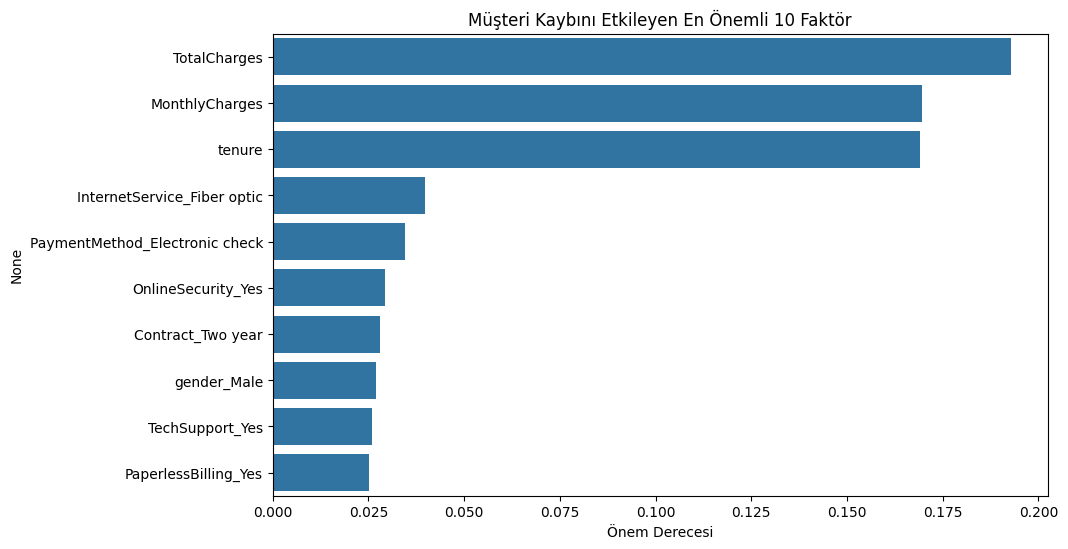

In [12]:
# Özelliklerin önem derecelerini alalım
onem_sirasi = pd.Series(rf_model.feature_importances_, index=X_train.columns)
onem_sirasi = onem_sirasi.sort_values(ascending=False).head(10) # En önemli 10 özellik

# Görselleştirelim
plt.figure(figsize=(10, 6))
sns.barplot(x=onem_sirasi, y=onem_sirasi.index)
plt.title("Müşteri Kaybını Etkileyen En Önemli 10 Faktör")
plt.xlabel("Önem Derecesi")
plt.show()